# Links between authors

In this notebook we will perform a basic analysis of the links between **authors** included in the Sefaria dataset.


## Setup

### Imports

In [1]:
import os
import json
import pathlib
import shutil
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

### Directories

In [2]:
dataset_dirname = "../sample_dataset/"
raw_subdirname = "raw/"
raw_metadata_subdirame = "_schemas/"
links_count_fn = dataset_dirname + raw_subdirname + '_links/links_by_book_without_commentary.csv'
output_subfolder = "./links_files/"

### Constants

Names of books we will want to merge in the analysis:


In [4]:
masekhtot = ['Arakhin', 'Bekhorot', 'Chullin', 'Keritot', 'Meilah', 'Menachot', 'Tamid', 'Temurah', 'Zevachim', 'Beitzah', 'Chagigah', 'Eruvin', 'Megillah', 'Moed Katan', 'Pesachim', 'Rosh Hashanah', 'Shabbat', 'Sukkah', 'Taanit', 'Yoma', 'Gittin', 'Ketubot', 'Kiddushin', 'Nazir', 'Nedarim', 'Sotah', 'Yevamot', 'Avodah Zarah', 'Bava Batra', 'Bava Kamma', 'Bava Metzia', 'Horayot', 'Makkot', 'Sanhedrin', 'Shevuot', 'Niddah', 'Berakhot']

torah_books = ['Deuteronomy', 'Exodus', 'Genesis', 'Leviticus', 'Numbers', 'Jeremiah', 'Job', 'Proverbs', 'Psalms']
#TODO: complete list
#TODO: merge mishnah books too

Threshold parameter for display of links in graph:


In [3]:
link_count_threshold = 500

## Load Authors List

We read the metadata files from the dataset. Every book's metadata is in a JSON file named after the book (after spaces are replaced by underscores). We load only a list of book/author from the files.



In [5]:
authors_dict = {}
error_count=0
metadata_dir = dataset_dirname + raw_subdirname + raw_metadata_subdirame

We loop over JSON files and extract author.

In some cases there is no "author" field in the JSON. For example: anonymous books (the author is unknown), eponymous books (the name of the author is in the title of the book). In thoses case we extract the author name from the book title, since often in Jewish Thought an author is nicknamed after his major creation. 

In [6]:
for metadata_fn in os.listdir(metadata_dir):
    filename, file_extension = os.path.splitext(metadata_fn)
    if file_extension != '.json':
        continue
    with open(metadata_dir+metadata_fn, 'r', encoding="utf8") as metadata_file:
        try:
            metadata = json.load(metadata_file)
        except:
            continue
    bookname = filename.replace('_', ' ')
    try:
        author = metadata['authors'][0]['en']
    except:
        on_idx = bookname.find(" on ")
        if on_idx>0:
            author = bookname[0:on_idx]
        else:
            author = bookname
        error_count+=1
    authors_dict[bookname] = author
print(str(error_count) + ' books out of '+ str(len(os.listdir(metadata_dir))) +' without valid author information were corrected.')

627 books out of 3095 without valid author information were corrected.


Convert to pandas dataframe and display preview:


In [7]:
book_authors_df = pd.DataFrame.from_dict(authors_dict, columns=['Author'], orient='index')
book_authors_df.head()

,Author
B'Mareh HaBazak Volume IX,Kollel Eretz Chemda
"Kessef Mishneh on Mishneh Torah, Nazariteship",Joseph Karo
"Melechet Shlomo on Mishneh Torah, Red Heifer",Shlomo Chakim
English Explanation of Mishnah Eduyot,Joshua Kulp
Tosefta Shevi'it,Tosefta Shevi'it


## Load links count data

We load the list of all (known) links between books from a CSV file.

In [8]:
all_links_counts = pd.read_csv(links_count_fn)
all_link_counts_filtered = all_links_counts[all_links_counts['Link Count']>=0]

Let's display some preview of the data:

In [9]:
all_link_counts_filtered.head()

,Text 1,Text 2,Link Count
0,Jastrow,Jastrow,56109
1,Klein Dictionary,Klein Dictionary,45992
2,Machatzit HaShekel on Orach Chayim,"Shulchan Arukh, Orach Chayim",15591
3,Bereishit Rabbah,Jastrow,5237
4,Jastrow,Shabbat,3745


## Build graph

We join the link counts list with the author list and keep only the "authors" and "link count" columns:

In [10]:
df1 = all_link_counts_filtered.join(book_authors_df, on='Text 1', rsuffix='_1')
df2 = df1.join(book_authors_df, on='Text 2', rsuffix='_2')
df2.rename(columns={'Author': 'Author_1'}, inplace=True)
authors_links_count = df2.loc[:,['Author_1', 'Author_2', 'Link Count']]
authors_links_count.head()

,Author_1,Author_2,Link Count
0,Marcus Jastrow,Marcus Jastrow,56109
1,Ernest Klein,Ernest Klein,45992
2,Machatzit HaShekel,"Shulchan Arukh, Orach Chayim",15591
3,Bereishit Rabbah,Marcus Jastrow,5237
4,Marcus Jastrow,Shabbat,3745


We merge some books which are port of one single corpus (Bible and Talmud) and remove the Jastrow dictionnary, since links from the Jastrow only mean this is a really exhaustive dictionnary:


In [11]:
authors_links_count.replace(masekhtot, 'Talmud', inplace=True)
authors_links_count.replace(torah_books, 'Bible', inplace=True)
idx2 = ~((authors_links_count['Author_2']=='Marcus Jastrow') | (authors_links_count['Author_1']=='Marcus Jastrow'))
authors_links_count = authors_links_count.loc[idx2]

We also remove self-references:


In [12]:
idx = ~authors_links_count['Author_1'].eq(authors_links_count['Author_2'])
authors_links_count = authors_links_count.loc[idx]

Aggregate identical rows and keep only links above threshold and save to file:

In [13]:
authors_links_count_agg = authors_links_count.groupby(['Author_1', 'Author_2']).sum()
authors_links_count_agg = authors_links_count_agg.reset_index() #or not?
# authors_links_count_agg.to_hdf(output_subfolder+"author_links.h5", "all_authors_links")

## Analysis of connections to reference corpuses

We want to vizualise major influences, certainly from reference sources common to most authors. To this end we keep only links above our defined threshold. Moreover, in order to improve the vizualization we remove midrashim.

In [14]:
authors_links_count_agg_morethan = authors_links_count_agg.loc[authors_links_count_agg['Link Count']>link_count_threshold]
midrashim_idx = (authors_links_count_agg_morethan['Author_2'].str.startswith('Midrash')) | (authors_links_count_agg_morethan['Author_1'].str.startswith('Midrash'))
authors_links_count_agg_morethan = authors_links_count_agg_morethan.loc[~midrashim_idx]

We create a Graph object, write to file and create a basic vizualization:


In [15]:
G_weighted_morethan = nx.Graph()
for index, row in authors_links_count_agg_morethan.iterrows():
    G_weighted_morethan.add_edge(row['Author_1'], row['Author_2'], weight=row['Link Count'])

    G = G_weighted_morethan
# nx.write_graphml(G_weighted_morethan, output_subfolder+'graphmorethan500.graphml')

Draw:

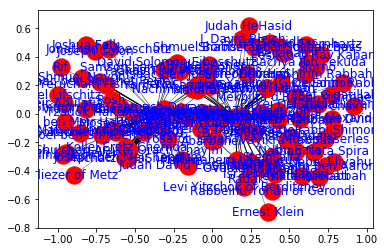

In [16]:
#code inspired by https://qxf2.com/blog/drawing-weighted-graphs-with-networkx/
pos=nx.spring_layout(G) 
nx.draw_networkx_nodes(G,pos, node_color='r')
nx.draw_networkx_labels(G,pos, font_color='b')
all_weights = []
for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness
#4 b. Get unique weights
unique_weights = list(set(all_weights))

#4 c. Plot the edges - one by one!
for weight in unique_weights:
    #4 d. Form a filtered list with just the weight you want to draw
    weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
    #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
    width = weight*2.0*G.number_of_nodes()/sum(all_weights)
    nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width)

plt.show()

That's not so clear. We use [Gephi](https://gephi.org/) to plot it more clearly, after further filtering of Midrashim and layout optimization. See in the `output_folder` defined at the beginning of the notebook for all relevant files.

The final result:

![Final Graph of large links](links_files/largelinks_vizualization.png "Optional title")

_The following code is not finished yet. Included for reference and to motivate feedback._

## Analysis of cross-connections between authors (under development)

We will now try to identify connections between authors themselves. To this end we will consider only link counts below some threshold.

In [21]:
authors_links_count_agg_lessthan = authors_links_count_agg.loc[authors_links_count_agg['Link Count']<=link_count_threshold]
footnotes_idx = (authors_links_count_agg_lessthan['Author_2'].str.contains('footnotes',case=False)) | (authors_links_count_agg_lessthan['Author_1'].str.contains('footnotes',case=False))
tosephta_idx = (authors_links_count_agg_lessthan['Author_2'].str.contains('tosefta',case=False)) | (authors_links_count_agg_lessthan['Author_1'].str.contains('tosefta',case=False))
mishna_idx = (authors_links_count_agg_lessthan['Author_2'].str.contains('mishna',case=False)) | (authors_links_count_agg_lessthan['Author_1'].str.contains('mishna',case=False))
talmud_idx = (authors_links_count_agg_lessthan['Author_2'].str.contains('talmud',case=False)) | (authors_links_count_agg_lessthan['Author_1'].str.contains('talmud',case=False))
midrash_idx = (authors_links_count_agg_lessthan['Author_2'].str.contains('midrash',case=False)) | (authors_links_count_agg_lessthan['Author_1'].str.contains('midrash',case=False))
tractate_idx = (authors_links_count_agg_lessthan['Author_2'].str.contains('tractate',case=False)) | (authors_links_count_agg_lessthan['Author_1'].str.contains('tractate',case=False))

idx_to_remove = footnotes_idx | tosephta_idx | mishna_idx | talmud_idx | midrash_idx | tractate_idx
authors_links_count_agg_lessthan = authors_links_count_agg_lessthan.loc[~idx_to_remove]

#TODO: remove bible sifra sifri midrash rabbah

G_weighted_lessthan = nx.Graph()
for index, row in authors_links_count_agg_lessthan.iterrows():
    G_weighted_lessthan.add_edge(row['Author_1'], row['Author_2'], weight=row['Link Count'])

    G = G_weighted_lessthan
nx.write_graphml(G_weighted_lessthan, output_subfolder+'graphlessthan500.graphml')